In [7]:
pip install gensim

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv("/content/drive/MyDrive/DataSet/Preprocessed_DonorsChoose_dataset.csv")

In [10]:
df.head()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            109248 non-null  object 
 1   teacher_prefix                                109248 non-null  object 
 2   school_state                                  109248 non-null  object 
 3   project_grade_category                        109248 non-null  object 
 4   project_subject_categories                    109248 non-null  object 
 5   project_subject_subcategories                 109248 non-null  object 
 6   teacher_number_of_previously_posted_projects  109248 non-null  int64  
 7   project_is_approved                           109248 non-null  int64  
 8   price                                         109248 non-null  float64
 9   quantity                                      10

(109248, 14)

Preprocessing

In [11]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['cleaned_essays'].apply(clean_text)
print(df[['cleaned_essays', 'clean_text']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                      cleaned_essays  \
0  students english learners working english seco...   
1  students arrive school eager learn polite gene...   
2  true champions not always ones win guts mia ha...   
3  work unique school filled esl english second l...   
4  second grade classroom next year made around 2...   

                                          clean_text  
0  student english learner working english second...  
1  student arrive school eager learn polite gener...  
2  true champion always one win gut mia hamm quot...  
3  work unique school filled esl english second l...  
4  second grade classroom next year made around k...  


tts

In [12]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['project_is_approved']  # Target (1=approved, 0=not approved)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))

Train size: 87398 Test size: 21850


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2))  # Uni+bi-grams
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)

TF-IDF shape: (87398, 2000)


In [14]:
import gensim.downloader as api
import numpy as np

w2v = api.load("word2vec-google-news-300")

def get_w2v_vector(text):
    words = text.split()
    words = [w for w in words if w in w2v]
    if len(words) == 0:
        return np.zeros(300)
    return np.mean([w2v[w] for w in words], axis=0)

X_train_w2v = np.vstack(X_train.apply(get_w2v_vector))
X_test_w2v = np.vstack(X_test.apply(get_w2v_vector))

print("Word2Vec shape:", X_train_w2v.shape)

Word2Vec shape: (87398, 300)


Logistic Regression (TF-IDF):
              precision    recall  f1-score   support

           0       0.59      0.04      0.07      3308
           1       0.85      1.00      0.92     18542

    accuracy                           0.85     21850
   macro avg       0.72      0.52      0.50     21850
weighted avg       0.81      0.85      0.79     21850



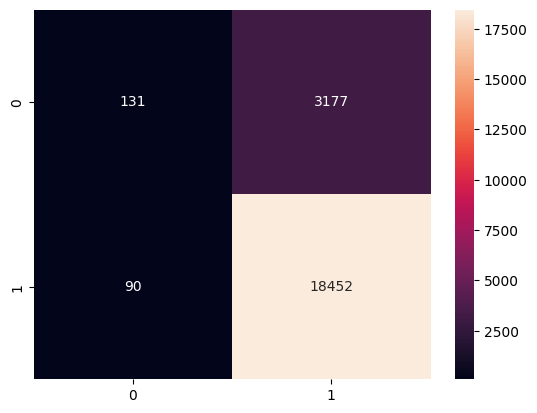

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression with TF-IDF
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

print("Logistic Regression (TF-IDF):")
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d")
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Convert TF-IDF sparse matrix to dense (small dataset is fine, else sample)
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Input 1: TF-IDF
input_tfidf = Input(shape=(X_train_tfidf_dense.shape[1],), name="tfidf_input")
x1 = layers.Dense(128, activation="relu")(input_tfidf)
x1 = layers.Dropout(0.3)(x1)

# Input 2: Word2Vec
input_w2v = Input(shape=(300,), name="w2v_input")
x2 = layers.Dense(128, activation="relu")(input_w2v)
x2 = layers.Dropout(0.3)(x2)

# Merge
merged = layers.concatenate([x1, x2])
x = layers.Dense(64, activation="relu")(merged)
output = layers.Dense(1, activation="sigmoid")(x)

# Build model
model = Model(inputs=[input_tfidf, input_w2v], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tfidf_input         │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ w2v_input           │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    256,128 │ tfidf_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     38,528 │ w2v_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 311,169 (1.19 MB)

 Trainable params: 311,169 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    [X_train_tfidf_dense, X_train_w2v],
    y_train,
    validation_data=([X_test_tfidf_dense, X_test_w2v], y_test),
    epochs=5,
    batch_size=16
)

# Evaluate
loss, acc = model.evaluate([X_test_tfidf_dense, X_test_w2v], y_test)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/5
5463/5463 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.8469 - loss: 0.4040 - val_accuracy: 0.8493 - val_loss: 0.3910
Epoch 2/5
5463/5463 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.8524 - loss: 0.3781 - val_accuracy: 0.8477 - val_loss: 0.3835
Epoch 3/5
5463/5463 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.8602 - loss: 0.3612 - val_accuracy: 0.8497 - val_loss: 0.3821
Epoch 4/5
5463/5463 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.8736 - loss: 0.3308 - val_accuracy: 0.8500 - val_loss: 0.3923
Epoch 5/5
5463/5463 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.8913 - loss: 0.2893 - val_accuracy: 0.8420 - val_loss: 0.4124
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8464 - loss: 0.4023
Test Accuracy: 0.8420


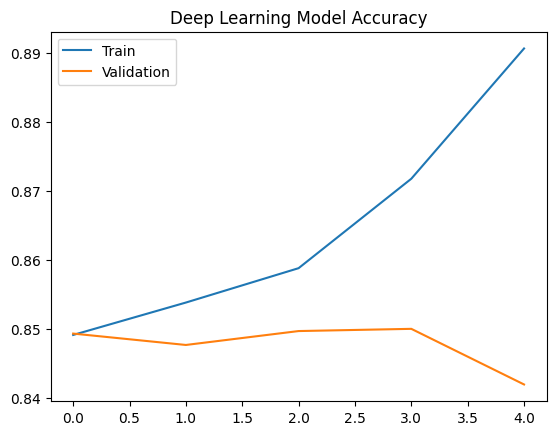

In [18]:
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.legend()
plt.title("Deep Learning Model Accuracy")
plt.show()